# Preamble
Here we train a YOLO (You Only Look Once) model to detect traffic signs.

# Import Libraries & Data

In [ ]:
!pip install ultralytics

In [313]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import glob
from PIL import Image

import ultralytics
from ultralytics import YOLO

In [4]:
!mkdir -p "data"
!mkdir -p "data/images"
!mkdir -p "data/images/train"
!mkdir -p "data/images/val"
!mkdir -p "data/images/test"
!mkdir -p "data/labels"
!mkdir -p "data/labels/train"
!mkdir -p "data/labels/val"
!mkdir -p "data/labels/test"
!mkdir -p "data/curl"

In [7]:
!curl -L -o ./data/curl/traffic-signs-dataset-in-yolo-format.zip\
  https://www.kaggle.com/api/v1/datasets/download/valentynsichkar/traffic-signs-dataset-in-yolo-format

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  250M  100  250M    0     0  30.4M      0  0:00:08  0:00:08 --:--:-- 34.0M


In [ ]:
!unzip ./data/curl/traffic-signs-dataset-in-yolo-format.zip -d ./data/curl

In [5]:
images_dir = "data/images"
labels_dir = "data/labels"

with open("./data/curl/train.txt" , "r", encoding="utf-8") as training_filenames_txt:
    for line in training_filenames_txt:
        line = line.strip()
        identifier = line[-9:-4] # "00433"
        img_file = identifier + ".jpg" # "00433.jpg"
        label_file = identifier + ".txt" # "00433.txt"

        # Move files
        shutil.copy("./data/curl/ts/ts/" + img_file, images_dir + "/train/" + img_file)
        shutil.copy("./data/curl/ts/ts/" + label_file, labels_dir + "/train/" + label_file)

with open("./data/curl/test.txt" , "r", encoding="utf-8") as testing_filenames_txt:
    for line in testing_filenames_txt:
        line = line.strip()
        identifier = line[-9:-4] # "00686"
        img_file = identifier + ".jpg" # "00686.jpg"
        label_file = identifier + ".txt" # "00686.txt"

        # Move files
        shutil.copy("./data/curl/ts/ts/" + img_file, images_dir + "/test/" + img_file)
        shutil.copy("./data/curl/ts/ts/" + label_file, labels_dir + "/test/" + label_file)

# Data Analysis

In [130]:
label_filenames_total = [
    filename
    for split in ['train', 'test', 'val']
    for filename in glob.glob(f'./data/labels/{split}/*.txt')
]

cols = ["filename", "category", "center_x", "center_y", "width", "height"]
rows = []

for filepath in label_filenames_total:
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            category, center_x, center_y, width, height = line.split()
            match category:
                case "0":
                    category = "prohibitory"
                case "1":
                    category = "danger"
                case "2":
                    category = "mandatory"
                case "3":
                    category = "other"
                case _:
                    print("somethings wrong") # TODO: Throw data error instead

            rows.append({
                "filename": filepath[-9:-4],
                "category": category,
                "center_x": float(center_x),
                "center_y": float(center_y),
                "width": float(width),
                "height": float(height)
            })

sign_data = pd.DataFrame(rows, columns = cols)

In [311]:
sign_data.head()

filename     category  center_x  center_y     width   height
0    00232    mandatory  0.443382  0.636875  0.020588  0.03625
1    00232        other  0.653676  0.498750  0.030882  0.05000
2    00232        other  0.234191  0.549375  0.031618  0.04875
3    00554       danger  0.709926  0.611875  0.027206  0.04375
4    00226  prohibitory  0.872059  0.321250  0.050000  0.08250

In [312]:
print(sign_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1213 non-null   object 
 1   category  1213 non-null   object 
 2   center_x  1213 non-null   float64
 3   center_y  1213 non-null   float64
 4   width     1213 non-null   float64
 5   height    1213 non-null   float64
dtypes: float64(4), object(2)
memory usage: 57.0+ KB
None


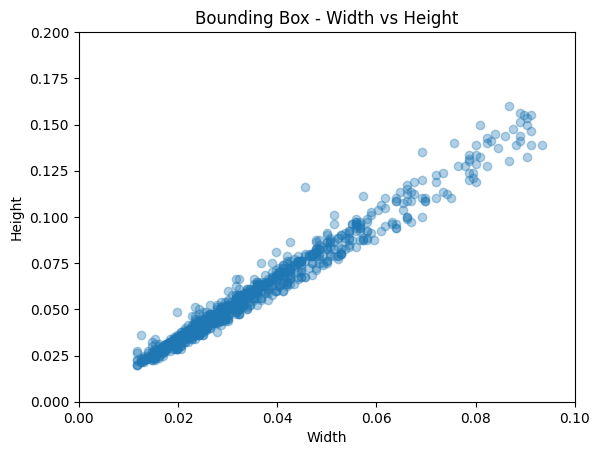

In [142]:
# Scatterplot of bounding box dimensions
OPACITY = 0.35

plt.scatter(sign_data['width'], 
            sign_data['height'], 
            alpha=OPACITY)

plt.xlim(left=0, right=0.10)
plt.ylim(bottom=0, top=0.20)

plt.title('Bounding Box - Width vs Height')
plt.xlabel('Width')
plt.ylabel('Height')

plt.show()

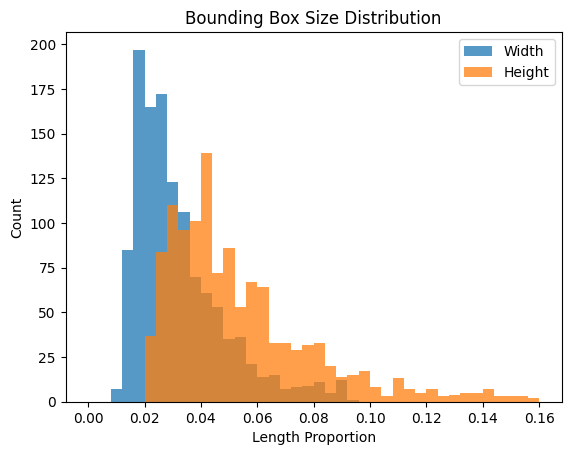

In [132]:
# Histogram of width and height distribution
OPACITY = 0.75

max_val = max(sign_data['width'].max(), sign_data['height'].max())
bin_width = 0.004
BINS = np.arange(0, max_val + bin_width, bin_width)

plt.hist(sign_data['width'], 
         label="Width", 
         alpha=OPACITY,
         bins=BINS
        )
plt.hist(sign_data['height'], 
         label="Height", 
         alpha=OPACITY,
         bins=BINS,
        )

plt.title('Bounding Box Size Distribution')
plt.xlabel('Length Proportion')
plt.ylabel('Count')
plt.legend()

plt.show()

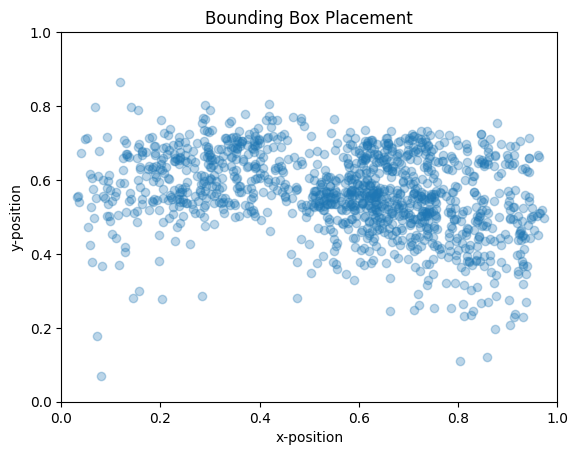

In [332]:
# Scatterplot of bounding box placement
OPACITY = 0.30

plt.scatter(sign_data['center_x'], 
            sign_data['center_y'], 
            alpha=OPACITY)

plt.xlim(left=0, right=1)
plt.ylim(bottom=0, top=1)

plt.title('Bounding Box Placement')
plt.xlabel('x-position')
plt.ylabel('y-position')

plt.show()

In [314]:
def box_colour_lookup(category): 
    match category:
        case "prohibitory":
            return '#0629ff', '#e3e3ff'
        case "danger":
            return '#09dbeb', '#2e3980'
        case "mandatory":
            return '#f3f3f3', '#2e3980'
        case "other":
            return '#00dfb5', '#2e3980'
        case _:
            return '#000000', '#000000' # TODO: Throw an exception here

# Visualize sample images and bounding boxes
LINE_WIDTH = 2
FONT_SIZE = 15

def image_and_bounding_box(image_path, df, n=5):
    images = glob.glob(f'{image_path}/*.jpg')[:n]
    for img_path in images:
        filename = img_path[-9:-4]

        # Draw image
        img = Image.open(image_path + "/" + filename + ".jpg")
        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Draw bounding boxes
        ax = plt.gca()
        for index, row in df.loc[df['filename'] == filename].iterrows():
            bg_col, text_col = box_colour_lookup(row['category'])

            # Pixel coordinates correspond to top-left of bounding box
            pixel_x = img.width * (row['center_x'] - 0.5 * row['width'])
            pixel_y = img.height * (row['center_y'] - 0.5 * row['height'])
            pixel_width = row['width'] * img.width
            pixel_height = row['height'] * img.height
            
            rect = patches.Rectangle((pixel_x, pixel_y), pixel_width, pixel_height,
                                     linewidth=LINE_WIDTH, 
                                     edgecolor=bg_col, 
                                     facecolor='none')
            ax.add_patch(rect)
            ax.text(pixel_x - LINE_WIDTH, 
                    pixel_y - LINE_WIDTH, 
                    row['category'], 
                    color=text_col, 
                    bbox=dict(facecolor=bg_col, edgecolor='none', pad=0.0),
                    fontsize=FONT_SIZE)

        plt.axis('off')
        plt.show()

        

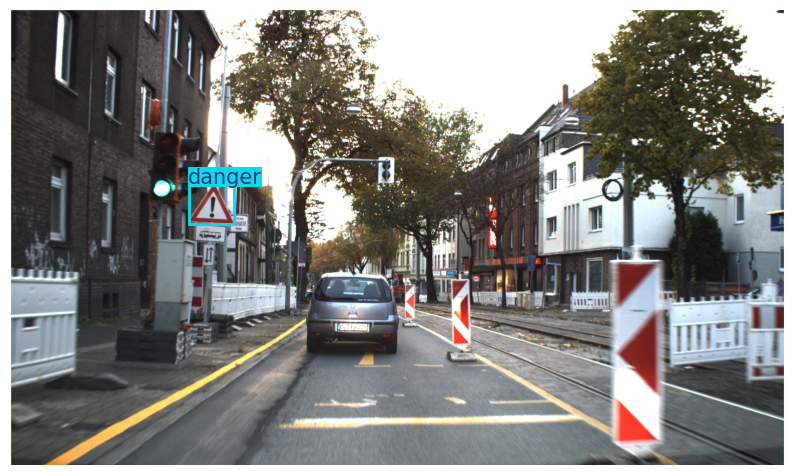

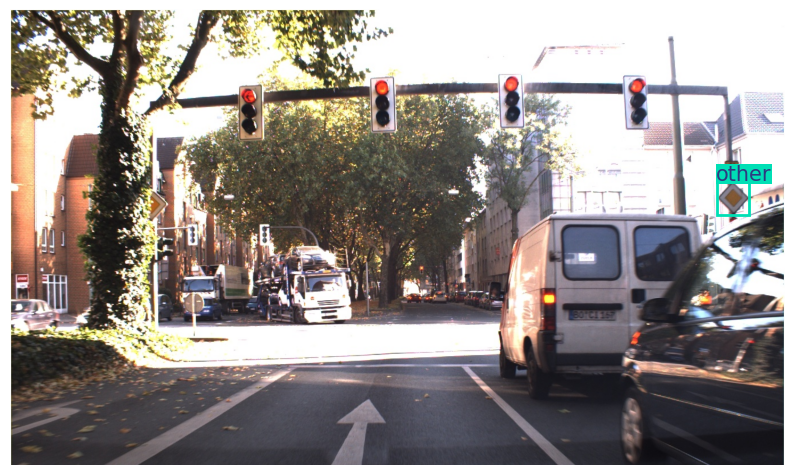

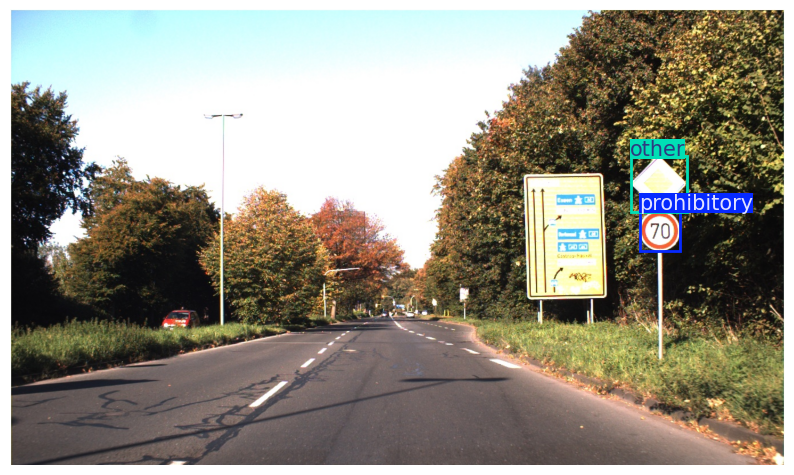

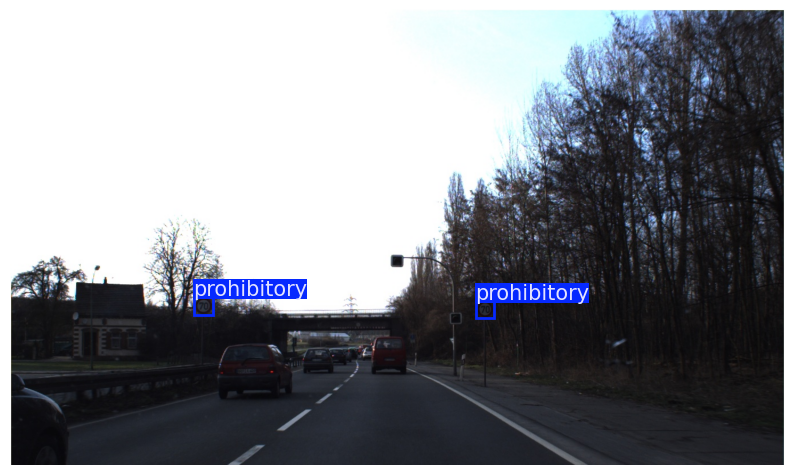

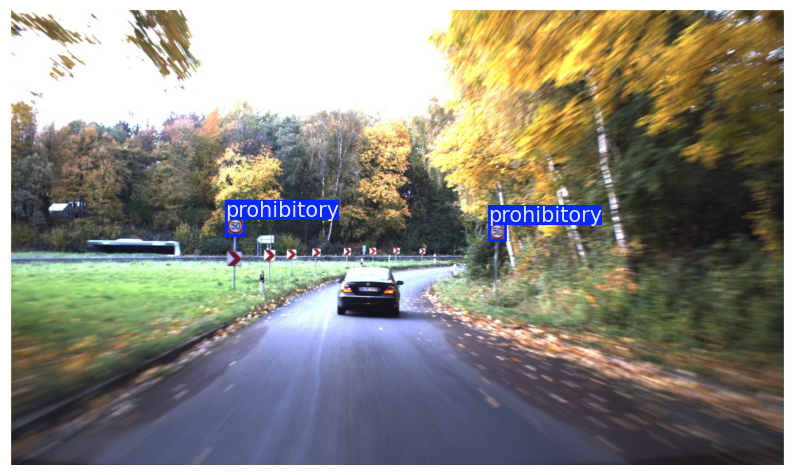

In [315]:
image_and_bounding_box(image_path="./data/curl/ts/ts", df=sign_data, n=5)

# Train Model

In [2]:
# Loads model saved on disk; if you have already trained
model = YOLO('runs/detect/sign_detection_model/weights/best.pt')

In [12]:
yaml_content = f"""
path: ./data
train: images/train
val: images/test

nc: 4
names: ['prohibitory', 'danger', 'mandatory', 'other']
"""

with open('sign_detection.yaml', 'w') as f:
    f.write(yaml_content)

In [3]:
 # Start with pretrained model, then train on traffic sign data
model = YOLO('yolo11n.pt')
results = model.train(
    data='sign_detection.yaml',
    epochs=10,
    imgsz=640,
    batch=16,
    name='sign_detection_model'
)

Ultralytics 8.3.163 🚀 Python-3.11.6 torch-2.7.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=sign_detection.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=sign_detection_model9, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

train: Scanning /Users/albertcao/Repos/traffic_signs/data/labels/train.cache... 630 images, 0 backgrounds, 0 corrupt: 100%|██████████| 630/630 [00:00<?, ?it/s]

train: /Users/albertcao/Repos/traffic_signs/data/images/train/00340.jpg: 1 duplicate labels removed
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3440.6±2181.2 MB/s, size: 342.1 KB)



val: Scanning /Users/albertcao/Repos/traffic_signs/data/labels/test.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]

Plotting labels to runs/detect/sign_detection_model9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/sign_detection_model9
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.356      4.913     0.9224          9        640: 100%|██████████| 40/40 [02:59<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]

                   all        111        179   9.33e-05    0.00694   5.82e-05   5.82e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/10         0G      1.192      3.215     0.8921          9        640: 100%|██████████| 40/40 [02:58<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]

                   all        111        179    0.00323      0.505      0.327      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/10         0G      1.129      2.748     0.8818          7        640: 100%|██████████| 40/40 [02:59<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        111        179      0.992      0.413      0.782      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/10         0G      1.041       2.19     0.8753          8        640: 100%|██████████| 40/40 [02:58<00:00,  4.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        111        179      0.843      0.635      0.775      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/10         0G     0.9967      1.912     0.8496          6        640: 100%|██████████| 40/40 [02:57<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        111        179      0.862      0.687      0.811      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/10         0G     0.9302      1.611     0.8472          8        640: 100%|██████████| 40/40 [02:58<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]

                   all        111        179      0.907      0.758      0.867      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/10         0G     0.9603      1.545     0.8517          9        640: 100%|██████████| 40/40 [02:57<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.03s/it]

                   all        111        179       0.89      0.799      0.868      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/10         0G      0.904      1.416     0.8413          9        640: 100%|██████████| 40/40 [02:58<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]

                   all        111        179      0.915      0.806      0.875      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/10         0G     0.8285      1.275     0.8318          9        640: 100%|██████████| 40/40 [02:58<00:00,  4.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

                   all        111        179      0.887      0.828      0.877      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/10         0G     0.8065      1.252     0.8257          9        640: 100%|██████████| 40/40 [02:57<00:00,  4.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]

                   all        111        179      0.883      0.835      0.886      0.717

10 epochs completed in 0.519 hours.
Optimizer stripped from runs/detect/sign_detection_model9/weights/last.pt, 5.4MB


Optimizer stripped from runs/detect/sign_detection_model9/weights/best.pt, 5.4MB

Validating runs/detect/sign_detection_model9/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.6 torch-2.7.1 CPU (Apple M3 Pro)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


                   all        111        179      0.882      0.835      0.886      0.716
           prohibitory         51         71      0.801      0.887      0.925      0.754
                danger         30         36       0.96          1      0.994       0.83
             mandatory         23         23      0.855      0.739      0.814      0.658
                 other         36         49      0.913      0.714      0.812       0.62
Speed: 0.3ms preprocess, 64.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/sign_detection_model9


In [316]:
results = model.val()

Ultralytics 8.3.163 🚀 Python-3.11.6 torch-2.7.1 CPU (Apple M3 Pro)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2914.9±4029.1 MB/s, size: 369.4 KB)


val: Scanning /Users/albertcao/Repos/traffic_signs/data/labels/test.cache... 111 images, 0 backgrounds, 0 corrupt: 100%|██████████| 111/111 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


                   all        111        179      0.882      0.835      0.886      0.716
           prohibitory         51         71      0.801      0.887      0.925      0.754
                danger         30         36       0.96          1      0.994       0.83
             mandatory         23         23      0.855      0.739      0.814      0.658
                 other         36         49      0.913      0.714      0.812       0.62
Speed: 0.3ms preprocess, 74.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val



0: 384x640 1 other, 23.2ms
1: 384x640 2 others, 23.2ms
2: 384x640 (no detections), 23.2ms
3: 384x640 1 prohibitory, 1 mandatory, 23.2ms
4: 384x640 1 danger, 23.2ms
5: 384x640 3 mandatorys, 2 others, 23.2ms
Speed: 1.1ms preprocess, 23.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


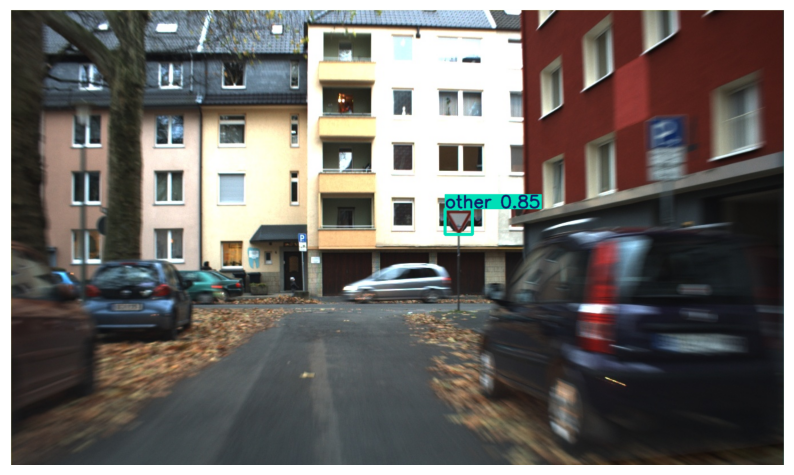

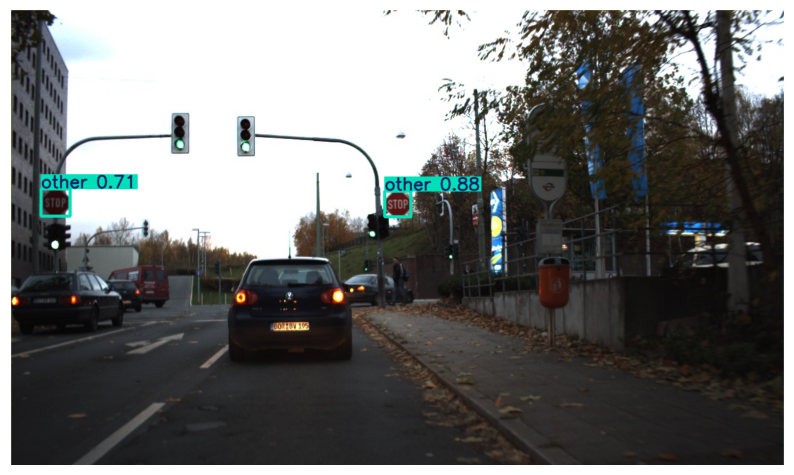

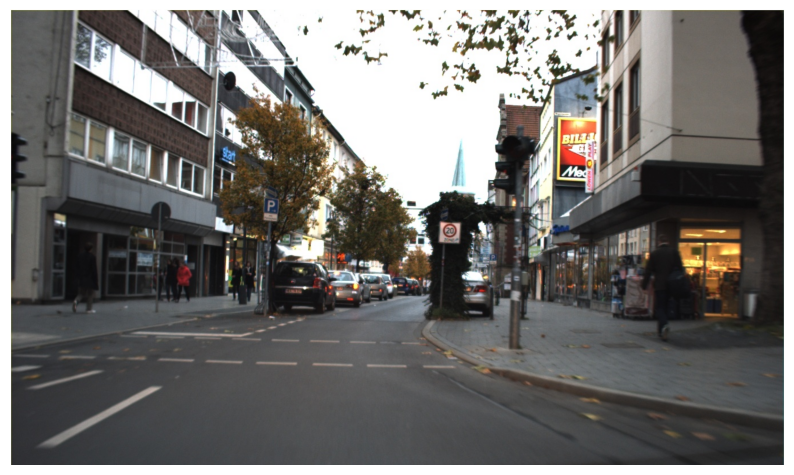

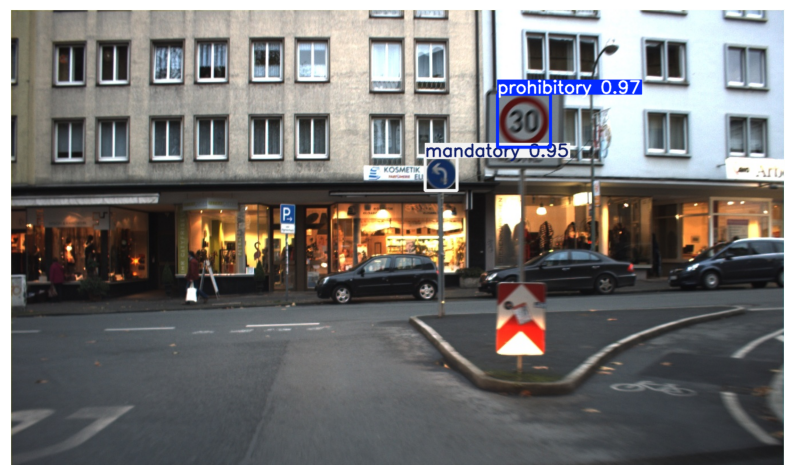

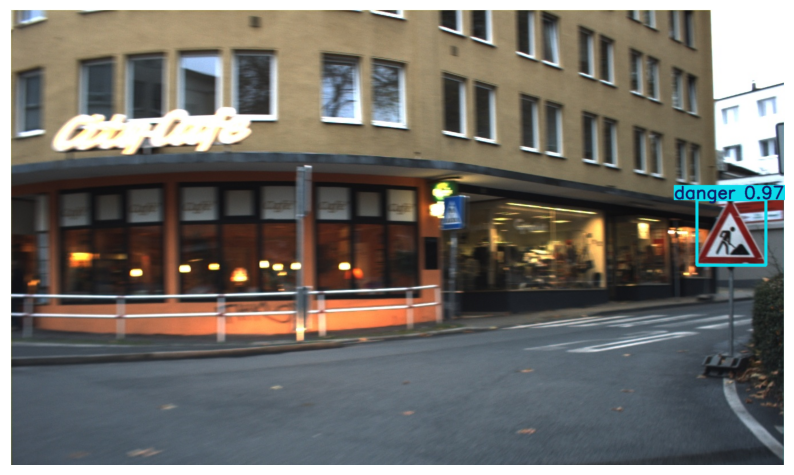

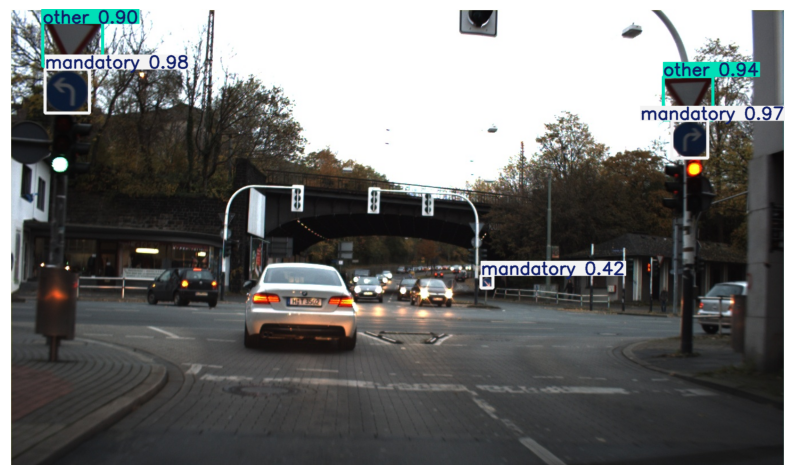

In [319]:
# Here are some inferences on sample images
results: ultralytics.engine.results.Results = model(['./data/curl/ts/ts/00201.jpg', 
        './data/curl/ts/ts/00202.jpg', 
        './data/curl/ts/ts/00203.jpg', 
        './data/curl/ts/ts/00204.jpg', 
        './data/curl/ts/ts/00205.jpg', 
        './data/curl/ts/ts/00206.jpg'])

for result in results:
    img_with_boxes = result.plot() 
    img_rgb = img_with_boxes[..., ::-1]

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()